In [1]:
import sys
sys.path.append('../../MembraneQuant')
from membranequant import *
%matplotlib notebook

# Load data

In [2]:
res = pd.read_csv('res.csv')
df = pd.read_csv('df.csv')
res_grouped = res.sort_values('Position').groupby('Frame')
df['mem_conc'] = res_grouped.apply(lambda x: bounded_mean_1d(x['Membrane signal'], [0.85, 0.15]))
df['cyt_conc'] = res_grouped.apply(lambda x: bounded_mean_1d(x['Cytoplasmic signal'], [0.85, 0.15]))

Subtracting cyt and mem values by mean n2 values. Ideally I wouldn't do this, but it seems like there's a small bias with slightly negative membrane concentrations for n2 on average

In [3]:
norm_x = np.mean(df['cyt_conc'][df.Line.isin(['n2b'])])
norm_y = np.mean(df['mem_conc'][df.Line.isin(['n2b'])])
# norm_x = 0
# norm_y = 0
df['cyt_conc'] = df['cyt_conc'] - norm_x
df['mem_conc'] = df['mem_conc'] - norm_y

# x = df['cyt_conc'][df.Line.isin(['lp637', 'nwg201'])] 
# y = df['mem_conc'][df.Line.isin(['lp637', 'nwg201'])] 
# x_wt = df['cyt_conc'][df.Line.isin(['lp637', 'nwg201']) & df.Condition.isin(['wt'])] 
# y_wt = df['mem_conc'][df.Line.isin(['lp637', 'nwg201']) & df.Condition.isin(['wt'])] 
# print(np.mean(y_wt/x_wt))
# print(np.std(y_wt/x_wt))

# x_c56s = df['cyt_conc'][df.Line.isin(['nwg246'])] 
# y_c56s = df['mem_conc'][df.Line.isin(['nwg246'])] 
# x_c56s_wt = df['cyt_conc'][df.Line.isin(['nwg246']) & df.Condition.isin(['wt'])] 
# y_c56s_wt = df['mem_conc'][df.Line.isin(['nwg246']) & df.Condition.isin(['wt'])] 
# print(np.mean(y_c56s_wt/x_c56s_wt))
# print(np.std(y_c56s_wt/x_c56s_wt))

# Linear model

Using ODR fitting as there is uncertainty in both x and y. I do an initial OLS fit, which doesn't require an initial guess, and use this as initial guess for ODR

In [4]:
import scipy.odr as odr
from scipy.optimize import curve_fit

def fitting(cyt, mem):
    # Ols fit
    popt, pcov = curve_fit(lambda x, a: a * x, cyt, mem)
    a_min_0 = popt[0]

    # Odr fit
    def perform_odr(x, y):
        quadr = odr.Model(lambda B, x: B[0] * x)
        mydata = odr.Data(x, y)
        myodr = odr.ODR(mydata, quadr, beta0=[a_min_0])
        output = myodr.run()
        return output

    regression = perform_odr(cyt, mem)
    a_min = regression.beta[0]
    return a_min

In [5]:
# a_lin = fitting(x, y)
# a_lin_c56s = fitting(x_c56s, y_c56s)

# Dimerisation model

Thermodynamic equilibrium models propose a quatratic relationship between cytoplasmic and membrane concentrations, assuming strong dimerisation on the membrane and no dimerisation in the cytoplasm

In [6]:
import scipy.odr as odr
from scipy.optimize import curve_fit

def fitting(cyt, mem):
    # Ols fit
    popt, pcov = curve_fit(lambda x, a: a * (x ** 2), cyt, mem)
    a_min_0 = popt[0]

    # Odr fit
    def perform_odr(x, y):
        quadr = odr.Model(lambda B, x: B[0] * (x ** 2))
        mydata = odr.Data(x, y)
        myodr = odr.ODR(mydata, quadr, beta0=[a_min_0])
        output = myodr.run()
        return output

    regression = perform_odr(cyt, mem)
    a_min = regression.beta[0]
    return a_min

In [7]:
# a_dim = fitting(x, y)
# a_dim_c56s = fitting(x_c56s, y_c56s)
# print(a_dim)

# Free exponent

Not sure what the biological implications of this are

In [8]:
import scipy.odr as odr
from scipy.optimize import curve_fit

def fitting(cyt, mem):
    # Ols fit
    popt, pcov = curve_fit(lambda x, a, b: a * (x ** b), cyt, mem)
    a_min_0, b_min_0 = popt

    # Odr fit
    def perform_odr(x, y):
        quadr = odr.Model(lambda B, x: B[0] * (x ** B[1]))
        mydata = odr.Data(x, y)
        myodr = odr.ODR(mydata, quadr, beta0=[a_min_0, b_min_0])
        output = myodr.run()
        return output

    regression = perform_odr(cyt, mem)
    a_min, b_min = regression.beta
    return a_min, b_min

In [9]:
# a_free, b_free = fitting(x, y)
# a_free_c56s, b_free_c56s = fitting(x_c56s, y_c56s)
# print(b_free)
# print(b_free_c56s)

Bootstrap fitting to get confidence interval

In [10]:
def bootstrap_fitting(cyts, mems, n=1000):
    a = np.zeros(n)
    b = np.zeros(n)

    for i in range(n):  
        inds = np.random.choice(range(len(cyts)), len(cyts))
        a[i], b[i] = fitting(cyts.to_numpy()[inds], mems.to_numpy()[inds])
    return a, b

def confidence_interval(cyts, mems, n_bootsrap=1000, n_x=100, interval=95):
    a, b = bootstrap_fitting(cyts, mems)
    
    x = np.linspace(0, max(cyts), n_x)
    all_fits = a[:, np.newaxis] * x[np.newaxis, :] ** b[:, np.newaxis]
    all_fits_lower = np.percentile(all_fits, (100 - interval) / 2, axis=0)
    all_fits_upper = np.percentile(all_fits, 50 + (interval / 2), axis=0)

    return x, all_fits_lower, all_fits_upper

# Compare fits

In [11]:
def func(xdata, ydata, c, fig=None, ax=None):
    
    if not ax:
        fig, ax = plt.subplots()
        
    a, b = fitting(xdata, ydata)
    cix, cil, ciu = confidence_interval(xdata, ydata, interval=99)
    print(b)

    ax.scatter(xdata/1000, ydata/1000, facecolors='none', edgecolors=c)
#     ax.plot(np.linspace(0, max(xdata), 100)/1000, a * (np.linspace(0, max(xdata), 100) ** b)/1000, c=c)
#     ax.fill_between(cix/1000, cil/1000, ciu/1000, color=c, alpha=0.1)
    
    ax.set_xlabel('Cytoplasmic concentration (a.u.)')
    ax.set_ylabel('Membrane concentration (a.u.)')
    ax.set_xlim()
    ax.set_xlim(left=0)
    ax.set_ylim(bottom=0)
    fig.set_size_inches(3.5, 3.5)
    fig.set_dpi(150)
    return fig, ax

<IPython.core.display.Javascript object>


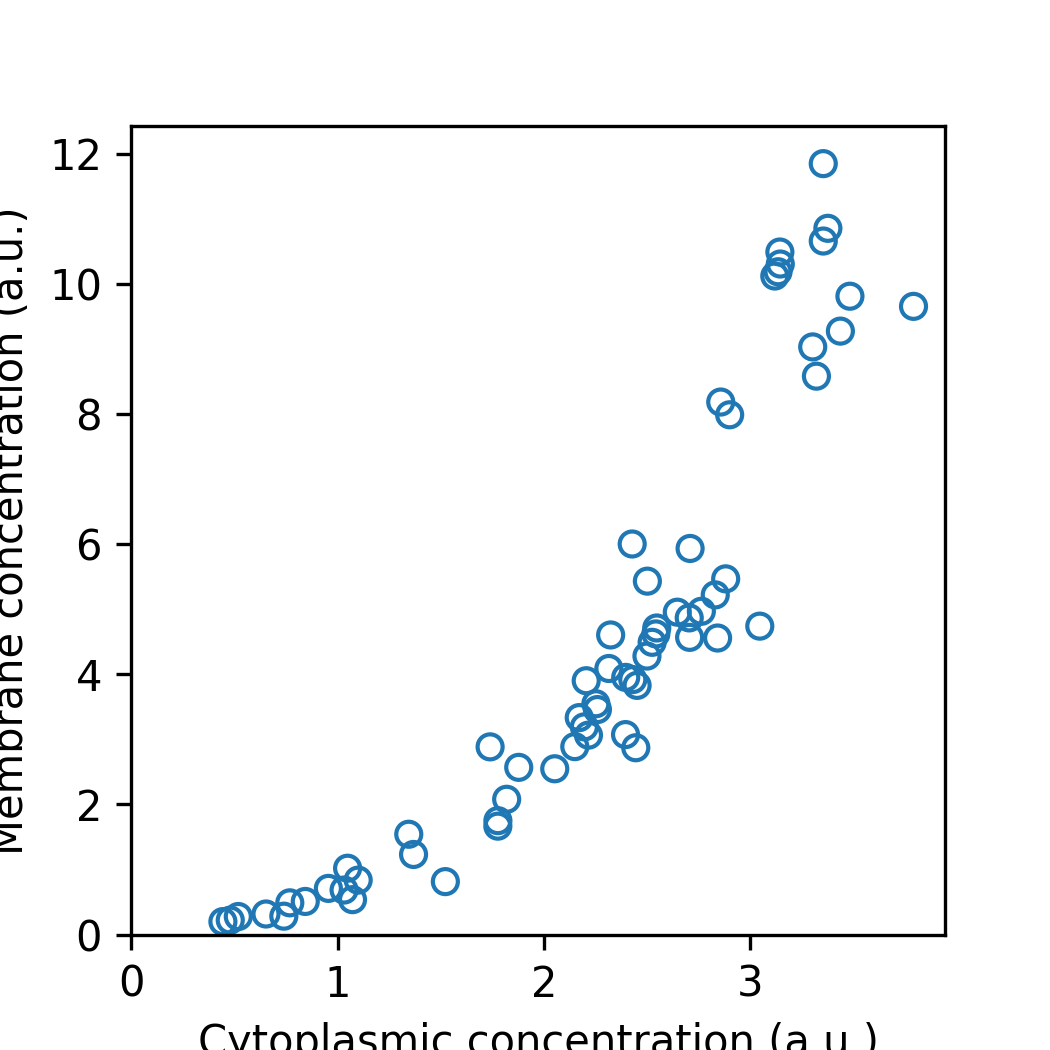

2.4407226721646538
2.1368869539243334


(<Figure size 525x525 with 1 Axes>,
 <AxesSubplot:xlabel='Cytoplasmic concentration (a.u.)', ylabel='Membrane concentration (a.u.)'>)

In [12]:
fig, ax = func(df['cyt_conc'][df.Line.isin(['lp637'])] , df['mem_conc'][df.Line.isin(['lp637'])], 'tab:blue')
func(df['cyt_conc'][df.Line.isin(['nwg201'])] , df['mem_conc'][df.Line.isin(['nwg201'])], 'tab:blue', fig, ax)

# func(df['cyt_conc'][df.Line.isin(['nwg201'])] , df['mem_conc'][df.Line.isin(['nwg201'])], 'tab:red')

<IPython.core.display.Javascript object>


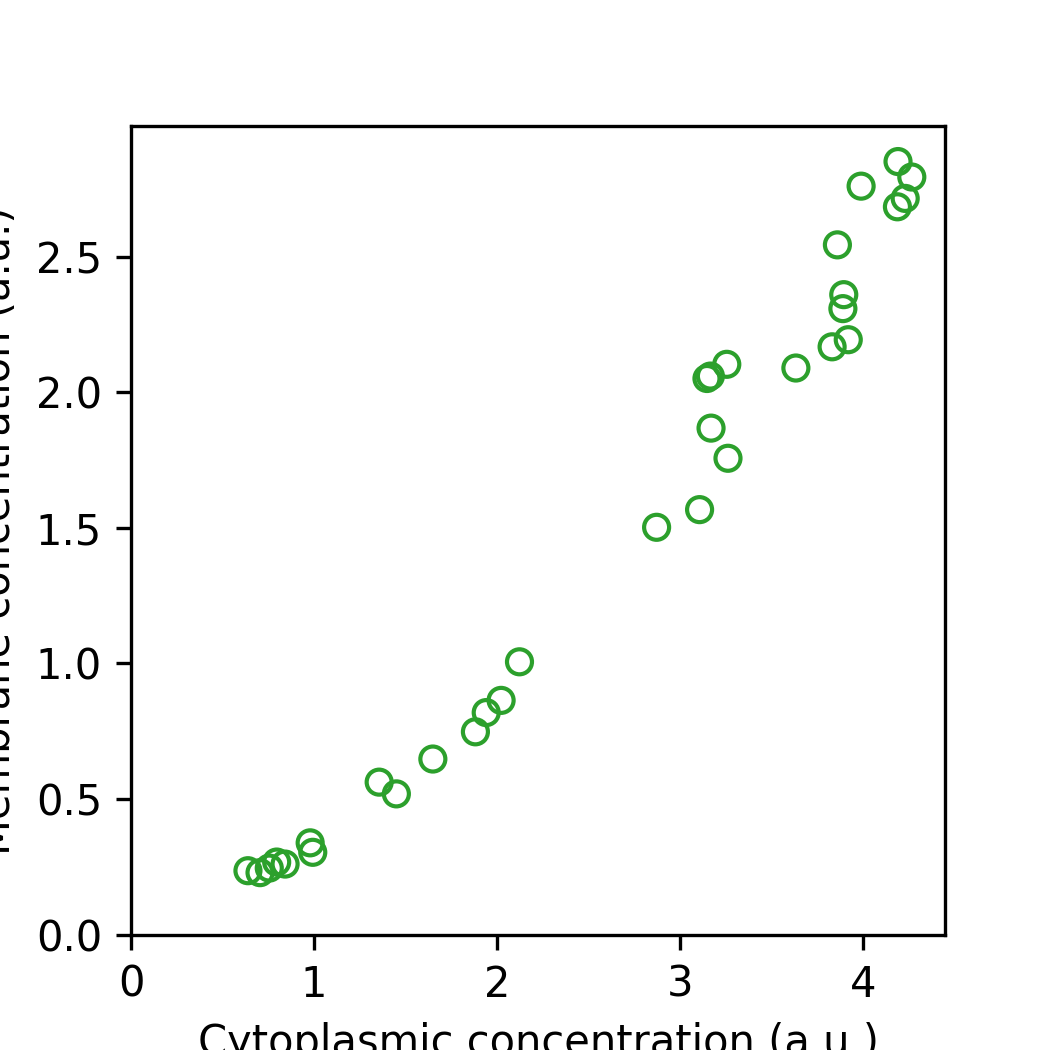

1.495025241049166


In [13]:
fig, ax = func(df['cyt_conc'][df.Line.isin(['nwg246'])] , df['mem_conc'][df.Line.isin(['nwg246'])], 'tab:green')

<IPython.core.display.Javascript object>


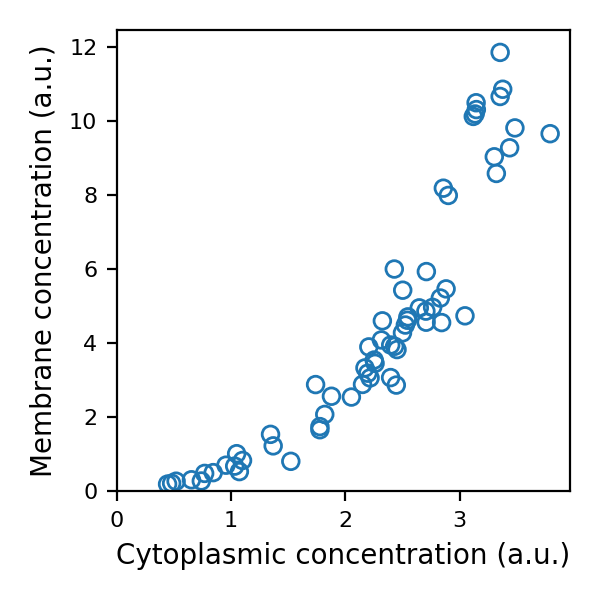

In [24]:
def func(xdata, ydata, c, fig=None, ax=None):
    ax.scatter(xdata/1000, ydata/1000, facecolors='none', edgecolors=c)

fig, ax = plt.subplots()
func(df['cyt_conc'][df.Line.isin(['lp637'])] , df['mem_conc'][df.Line.isin(['lp637'])], 'tab:blue', fig, ax)
func(df['cyt_conc'][df.Line.isin(['nwg201'])] , df['mem_conc'][df.Line.isin(['nwg201'])], 'tab:blue', fig, ax)
# func(df['cyt_conc'][df.Line.isin(['nwg246'])] , df['mem_conc'][df.Line.isin(['nwg246'])], 'tab:red', fig, ax)

ax.set_xlabel('Cytoplasmic concentration (a.u.)')
ax.set_ylabel('Membrane concentration (a.u.)')
ax.set_xlim(left=0)
ax.set_ylim(bottom=0)
# ax.axhline(0, c='k', linestyle='--', linewidth=1)
ax.tick_params(axis='both', labelsize=8)
fig.set_size_inches(3, 3)
fig.tight_layout()
fig.savefig('wt_rundown.png', dpi=600, transparent=True)

<IPython.core.display.Javascript object>


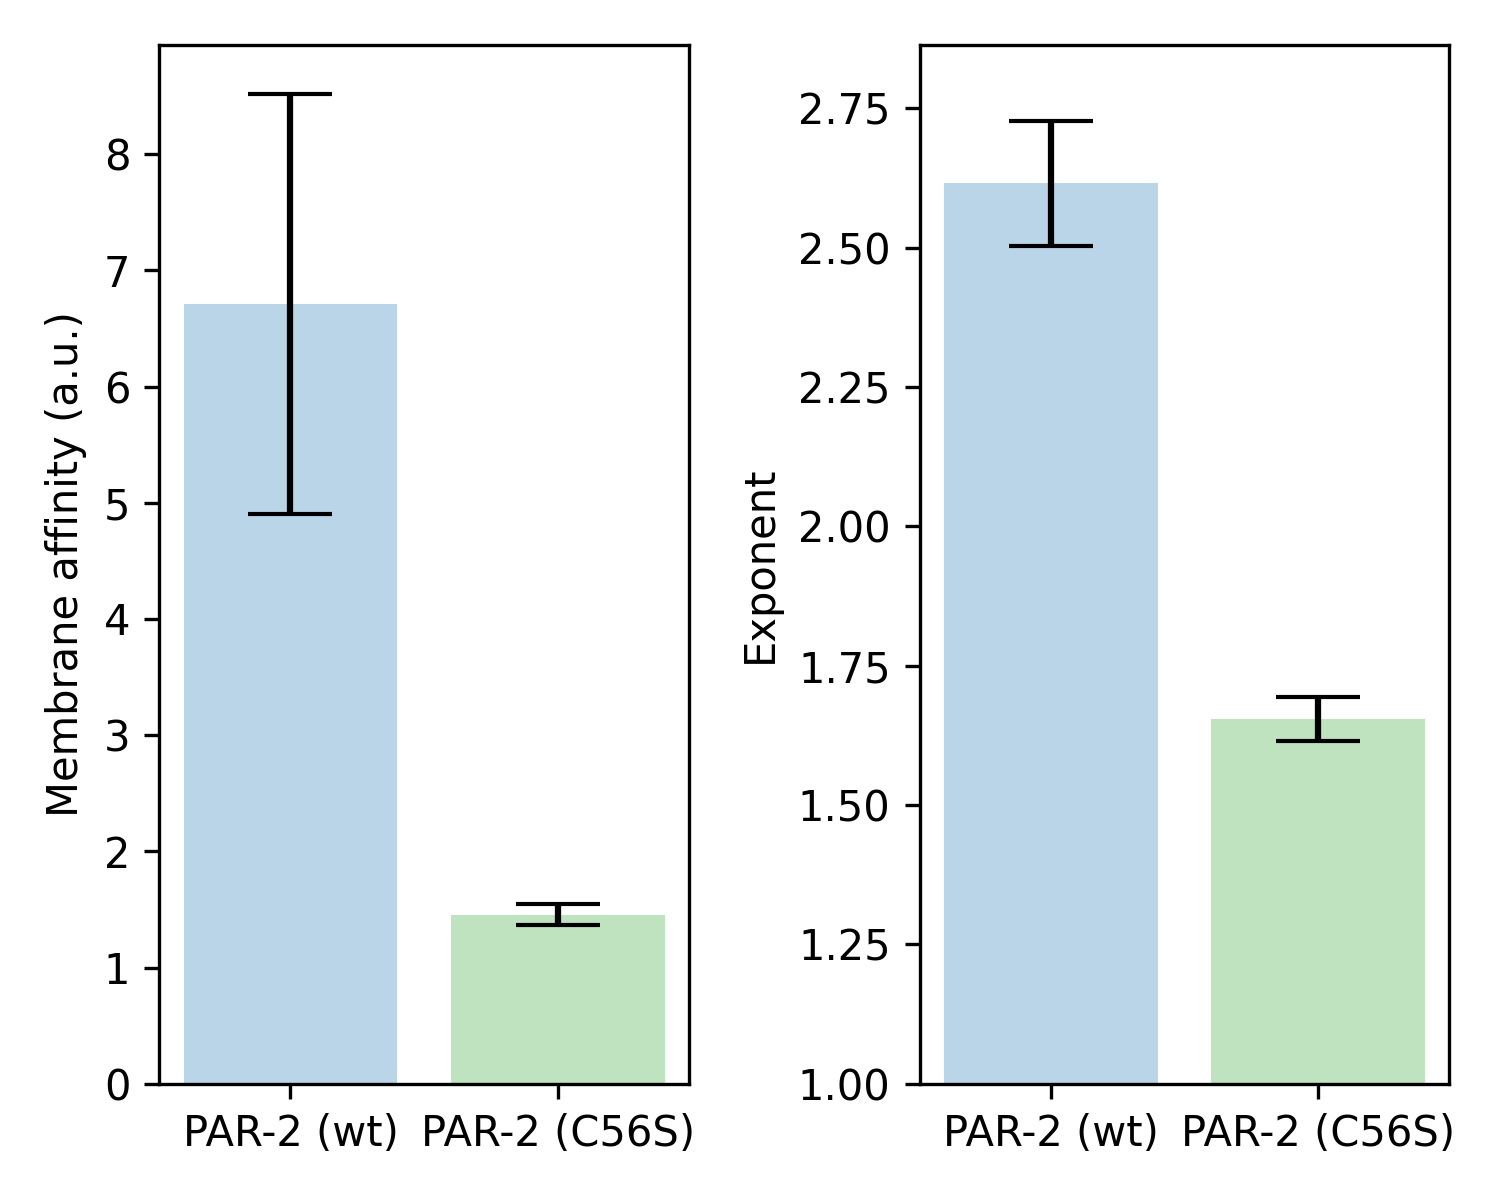

In [15]:
fig, (ax1, ax2) = plt.subplots(1,2)

# Membrane affinity
ax1.bar([1,2], [6.707330840249355, 1.4562780619521403], color=['tab:blue', 'tab:green'], alpha=0.3, yerr=[1.8060016525502627, 0.09261914625804621], capsize=10)
ax1.set_xticks([1,2])
ax1.set_xticklabels(['PAR-2 (wt)', 'PAR-2 (C56S)'])
ax1.set_ylabel('Membrane affinity (a.u.)')

# Non linearity
ax2.bar([1,2], [2.615826375909028, 1.654491389043195], color=['tab:blue', 'tab:green'], alpha=0.3, yerr=[0.11172882941516318, 0.039074979051389326], capsize=10)
ax2.set_xticks([1,2])
ax2.set_xticklabels(['PAR-2 (wt)', 'PAR-2 (C56S)'])
# ax2.axhline(1, c='k', linestyle='--')
ax2.set_ylabel('Exponent')
ax2.set_ylim(bottom=1)

fig.set_size_inches(5,4)
fig.tight_layout()
fig.set_dpi(150)

# Comparison with PH

<IPython.core.display.Javascript object>


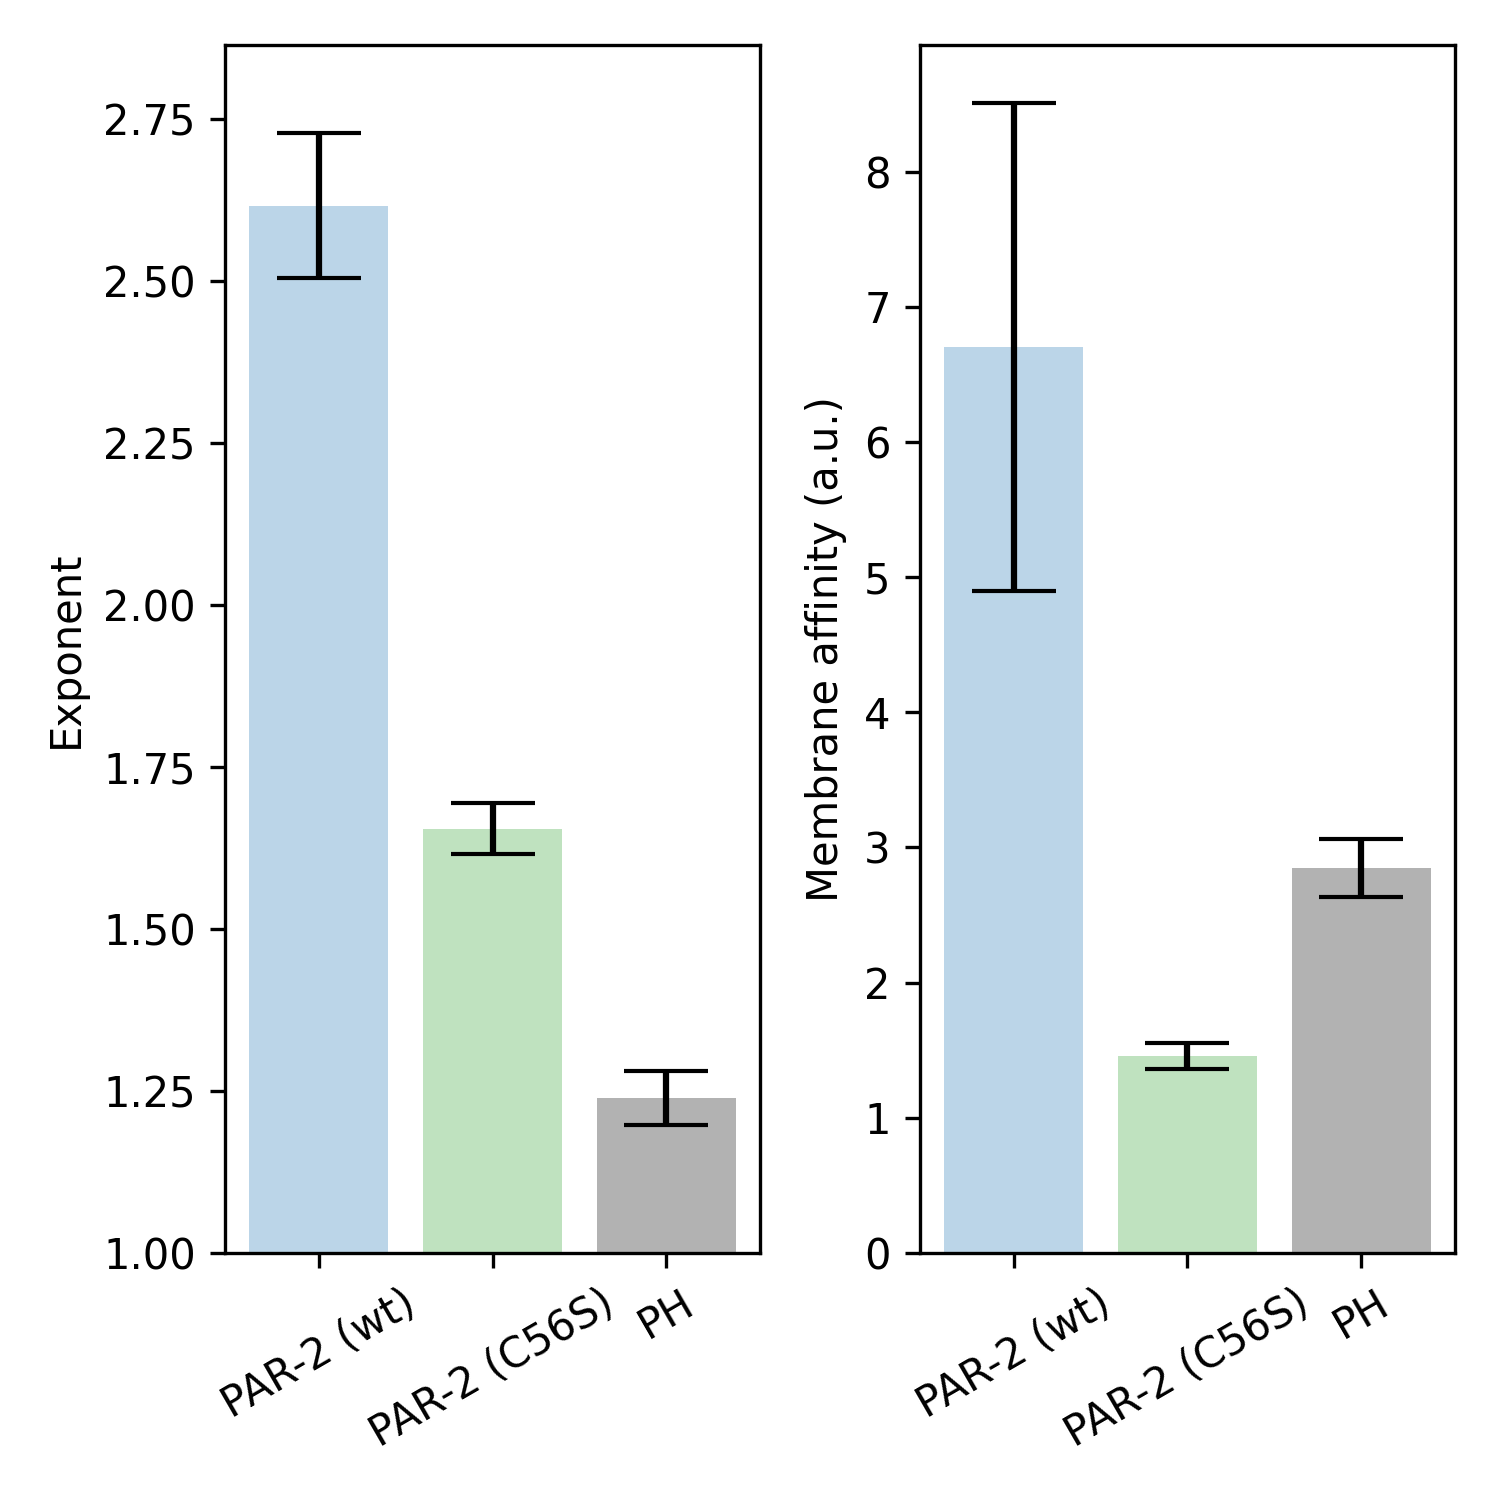

In [16]:
fig, (ax1, ax2) = plt.subplots(1,2)

# Non linearity
ax1.bar([1,2,3], [2.615826375909028, 1.654491389043195, 1.2385848598083873], color=['tab:blue', 'tab:green', 'k'], alpha=0.3, yerr=[0.11172882941516318, 0.039074979051389326, 0.041936973486103014], capsize=10)
ax1.set_xticks([1,2,3])
ax1.set_xticklabels(['PAR-2 (wt)', 'PAR-2 (C56S)', 'PH'], rotation=30)
# ax1.axhline(1, c='k', linestyle='--')
ax1.set_ylabel('Exponent')
ax1.set_ylim(bottom=1)

# Membrane affinity
ax2.bar([1,2,3], [6.707330840249355, 1.4562780619521403, 2.8483813071329505], color=['tab:blue', 'tab:green', 'k'], alpha=0.3, yerr=[1.8060016525502627, 0.09261914625804621, 0.21489423212344932], capsize=10)
ax2.set_xticks([1,2,3])
ax2.set_xticklabels(['PAR-2 (wt)', 'PAR-2 (C56S)', 'PH'], rotation=30)
ax2.set_ylabel('Membrane affinity (a.u.)')

fig.set_size_inches(5, 5)
fig.tight_layout()
fig.set_dpi(150)

<IPython.core.display.Javascript object>


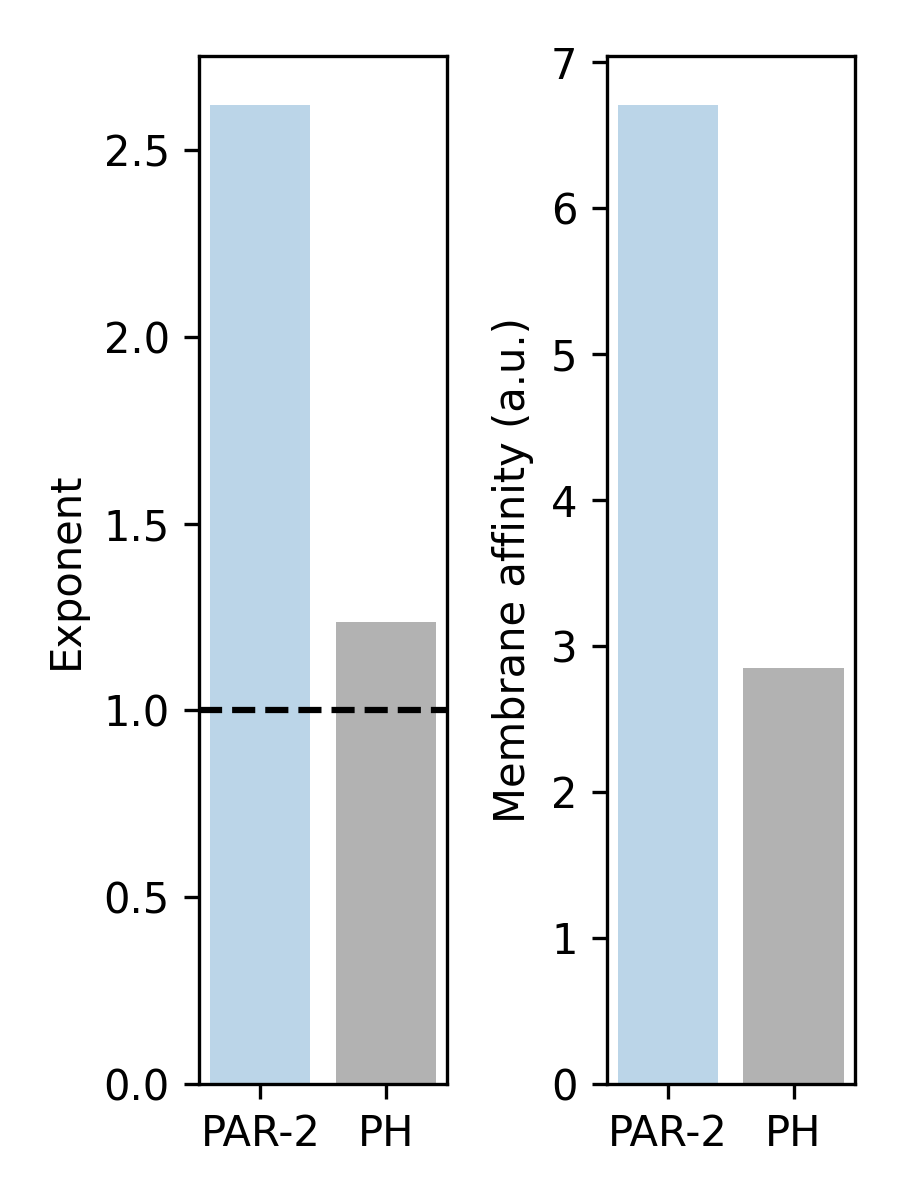

In [17]:
fig, (ax1, ax2) = plt.subplots(1,2)

# Non linearity
ax1.bar([1,2], [2.622065839823789,  1.2372846959268198], color=['tab:blue', 'k'], alpha=0.3)
ax1.set_xticks([1,2])
ax1.set_xticklabels(['PAR-2', 'PH'])
ax1.axhline(1, c='k', linestyle='--')
ax1.set_ylabel('Exponent')

# Membrane affinity
ax2.bar([1,2], [6.707330840249355, 2.8483813071329505], color=['tab:blue', 'k'], alpha=0.3)
ax2.set_xticks([1,2])
ax2.set_xticklabels(['PAR-2', 'PH'])
ax2.set_ylabel('Membrane affinity (a.u.)')

fig.set_size_inches(3,4)
fig.tight_layout()
fig.set_dpi(150)

In [18]:
# import seaborn as sns
# plt.plot(np.linspace(0,1,100), np.linspace(0,1,100) ** 2)
# plt.xlabel('Cytoplasm')
# plt.ylabel('Membrane')
# plt.xticks([])
# plt.yticks([])
# plt.gcf().set_size_inches(1.5,1.5)
# plt.gcf().set_dpi(150)
# sns.despine()

<IPython.core.display.Javascript object>


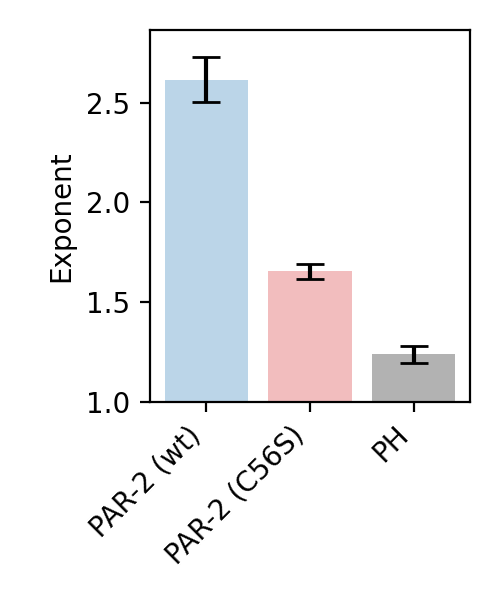

In [26]:
fig, ax1 = plt.subplots()

# Non linearity
ax1.bar([1,2,3], [2.615826375909028, 1.654491389043195, 1.2385848598083873], color=['tab:blue', 'tab:red', 'k'], 
        alpha=0.3, yerr=[0.11172882941516318, 0.039074979051389326, 0.041936973486103014], capsize=5)
ax1.set_xticks([1,2,3])
ax1.set_xticklabels(['PAR-2 (wt)', 'PAR-2 (C56S)', 'PH'], rotation=45, ha='right')
# ax1.axhline(1, c='k', linestyle='--')
ax1.set_ylabel('Exponent')
ax1.set_ylim(bottom=1)

fig.set_size_inches(2.5, 3)
fig.tight_layout()
fig.savefig('exponents_bar.png', dpi=600, transparent=True)